In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.chdir('..')

In [3]:
from src.models.exif_sc import EXIF_SC
import torch
import cv2
import numpy as np 
import time
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from src.datasets import (
    RealisticTamperingDataset,
    ColumbiaDataset,
    InTheWildDataset,
    SceneCompletionDataset,
    DSO_1_Dataset
)
import random
from src.structures import PatchedImage
from src.attacks.lots import PatchLOTS

In [4]:
ds = DSO_1_Dataset(spliced_only=True)
idx = 22
data = ds[idx]
clean_img = data['img']
gt_map = data['map']

In [5]:
clean_img.shape, gt_map.shape

(torch.Size([3, 1536, 2048]), (1536, 2048))

In [6]:
gt_map.shape

(1536, 2048)

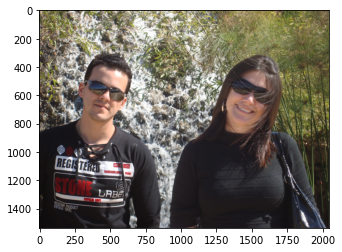

In [7]:
plt.imshow(clean_img.permute(1, 2, 0))

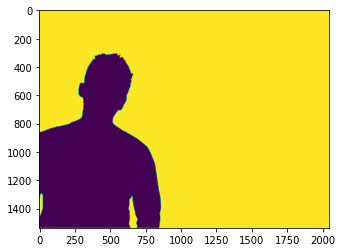

In [8]:
plt.imshow(gt_map)

In [14]:
img_shapes = []
map_shapes = []

for i in range(len(ds)):
    data = ds[i]
    img_shapes.append(list(data['img'].shape)[1:])
    map_shapes.append(list(data['map'].shape))

In [17]:
for i in range(len(ds)):
    if img_shapes[i] != map_shapes[i]:
        print(i)

2
22
55
62
79


In [4]:
ds = ColumbiaDataset(spliced_only=True)
# idx = random.randint(0, len(ds)-1)
idx = 68
data = ds[idx]
clean_img = data['img']
gt_map = data['map']

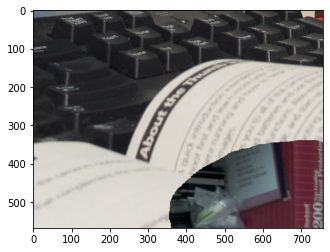

In [5]:
plt.imshow(clean_img.permute(1, 2, 0))

In [9]:
model = EXIF_SC("artifacts/exif_sc.npy", device="cuda:1")
for parameter in model.net.parameters():
    parameter.requires_grad = False

attack = PatchLOTS()

In [10]:
clean_pred = model.predict(clean_img)

/home/angyz/miniconda3/envs/fake-detection-lab/lib/python3.7/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


In [11]:
clean_pred['ms'].min(), clean_pred['ms'].max()

(0.023758516, 0.92552656)

In [21]:
adv_img = attack(
    model, 
    data,
    step_size=1000,
    n_iter=50,
)

Performing adversarial attack...
100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


In [9]:
adv_pred = model.predict(adv_img)

/home/angyz/miniconda3/envs/fake-detection-lab/lib/python3.7/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


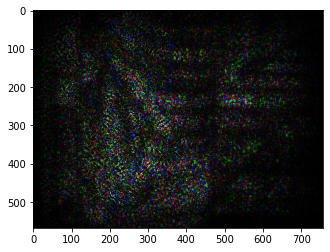

In [29]:
plt.imshow((adv_img - img_raw).permute(1, 2, 0) * 10)

In [16]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
plots = {
    'Input Image': clean_img.permute(1, 2, 0),
    'Adv Image': adv_img.permute(1, 2, 0),
    'Cluster w/ MeanShift': clean_pred['ms'],
    
}

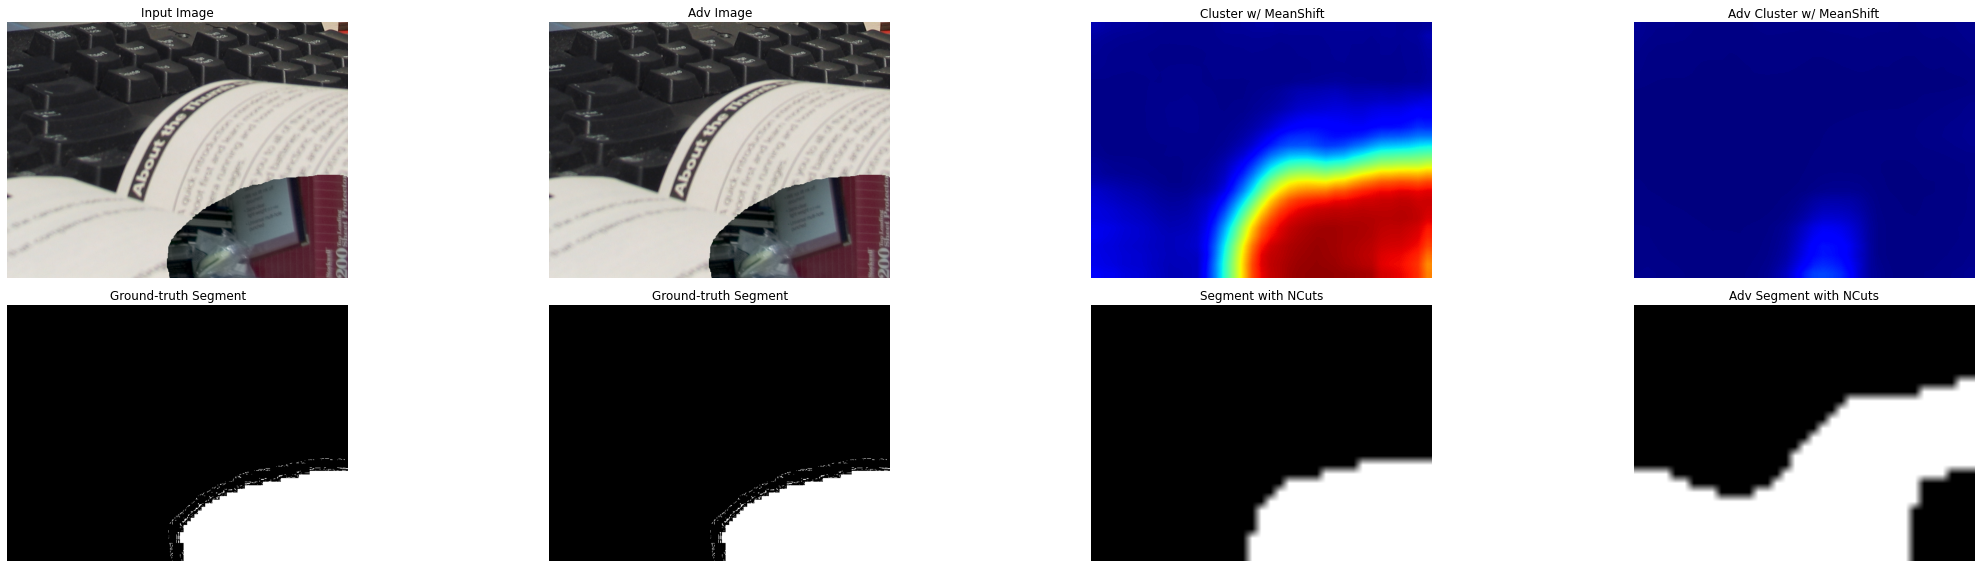

In [22]:
plt.subplots(figsize=(32, 8))
plt.subplot(2, 4, 1)
plt.title('Input Image')
plt.imshow(clean_img.permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 4, 2)
plt.title('Adv Image')
plt.imshow(adv_img.permute(1, 2, 0))
plt.axis('off')

plt.subplot(2, 4, 3)
plt.title('Cluster w/ MeanShift')
plt.axis('off')
plt.imshow(clean_pred['ms'], cmap='jet', vmin=0.0, vmax=1.0)

plt.subplot(2, 4, 4)
plt.title('Adv Cluster w/ MeanShift')
plt.axis('off')
plt.imshow(adv_pred['ms'], cmap='jet', vmin=0.0, vmax=1.0)

plt.subplot(2, 4, 5)
plt.title('Ground-truth Segment')
plt.axis('off')
plt.imshow(data['map'], vmin=0.0, vmax=1.0, cmap="gray")

plt.subplot(2, 4, 6)
plt.title('Ground-truth Segment')
plt.axis('off')
plt.imshow(data['map'], vmin=0.0, vmax=1.0, cmap="gray")

plt.subplot(2, 4, 7)
plt.title('Segment with NCuts')
plt.axis('off')
plt.imshow(clean_pred['ncuts'], vmin=0.0, vmax=1.0, cmap="gray")

plt.subplot(2, 4, 8)
plt.title('Adv Segment with NCuts')
plt.axis('off')
plt.imshow(adv_pred['ncuts'], vmin=0.0, vmax=1.0, cmap="gray")

plt.tight_layout()
plt.show()

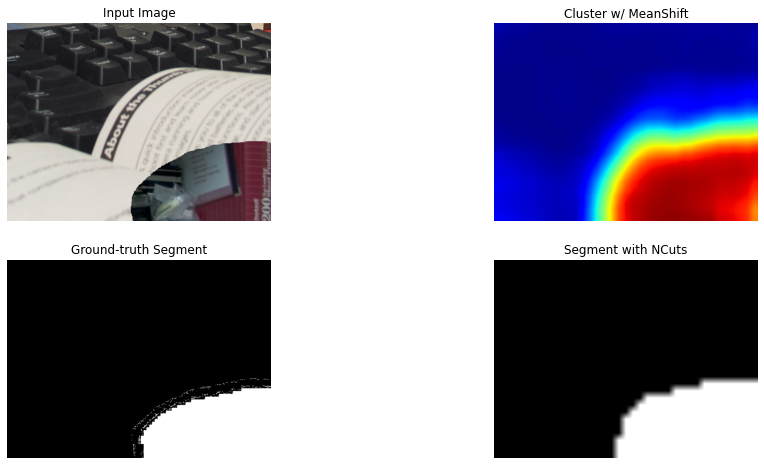

In [248]:
img_cv = img_raw.permute(1, 2, 0)

plt.subplots(figsize=(32, 8))
plt.subplot(2, 2, 1)
plt.title('Input Image')
plt.imshow(img_cv)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Cluster w/ MeanShift')
plt.axis('off')
plt.imshow(clean_preds['ms'], cmap='jet', vmin=0.0, vmax=1.0)

plt.subplot(2, 2, 3)
plt.title('Ground-truth Segment')
plt.axis('off')
plt.imshow(data['map'], vmin=0.0, vmax=1.0, cmap="gray")

plt.subplot(2, 2, 4)
plt.title('Segment with NCuts')
plt.axis('off')
plt.imshow(clean_preds['ncuts'], vmin=0.0, vmax=1.0, cmap="gray")

plt.show()

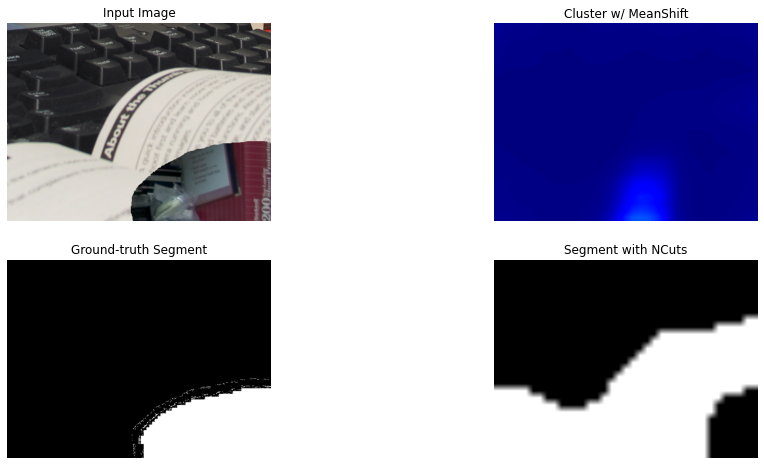

In [332]:
img_cv = img_raw.permute(1, 2, 0)

plt.subplots(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.title('Input Image')
plt.imshow(adv_img)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Cluster w/ MeanShift')
plt.axis('off')
plt.imshow(adv_preds['ms'], cmap='jet', vmin=0.0, vmax=1.0)

plt.subplot(2, 2, 3)
plt.title('Ground-truth Segment')
plt.axis('off')
plt.imshow(data['map'], vmin=0.0, vmax=1.0, cmap="gray")

plt.subplot(2, 2, 4)
plt.title('Segment with NCuts')
plt.axis('off')
plt.imshow(adv_preds['ncuts'], vmin=0.0, vmax=1.0, cmap="gray")

plt.show()